In [88]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)


file_sizes: 100%|█████████████████████████████| 170M/170M [00:01<00:00, 167MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

随机裁剪和调整大小+随机水平翻转

In [90]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"  # 数据集根目录
batch_size = 256  # 批量大小
image_size = 32  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 10  # 分类数量


def create_dataset_cifar10_strategy1(dataset_dir, usage, resize, batch_size, workers):
    
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        # 第一种数据增强策略
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),#随机裁剪操作，从图像中随机裁剪出大小为 32x32 的区域，裁剪时会在水平和垂直方向上各随机裁剪 4 个像素
            vision.RandomVerticalFlip(prob=0.5)#随机垂直翻转操作，以 0.5 的概率对图像进行水平翻转。
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # 数据映射操作
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set

# 获取处理后的训练与测试数据集

dataset_train = create_dataset_cifar10_strategy1(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10_strategy1(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

随机裁剪+随机旋转

In [43]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"  # 数据集根目录
batch_size = 256  # 批量大小
image_size = 32  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 10  # 分类数量


def create_dataset_cifar10_strategy2(dataset_dir, usage, resize, batch_size, workers):
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        # 第二种数据增强策略
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomRotation(15)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # 数据映射操作
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


# 获取处理后的训练与测试数据集

dataset_train = create_dataset_cifar10_strategy2(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10_strategy2(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

Image shape: (256, 3, 32, 32), Label shape: (256,)
Labels: [0 8 2 4 8 1]


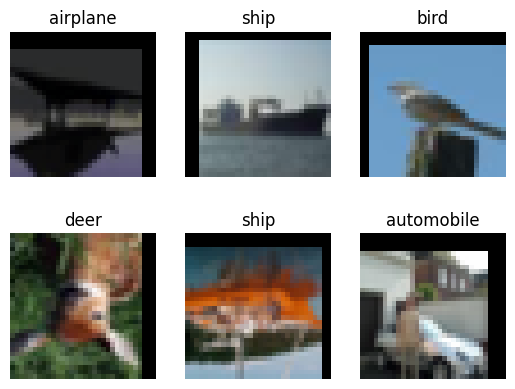

In [92]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")

classes = []

with open(data_dir + "/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

# 训练数据集的前六张图片
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

In [112]:
import mindspore.nn as nn
import numpy as np
import mindspore.ops as ops


class Classifier(nn.Cell):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn = nn.SequentialCell(
            nn.Conv2d(3, 64, 3, pad_mode='pad', padding=1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [64, 64, 64]

            nn.Conv2d(64, 128, 3, pad_mode='pad', padding=1),  # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [128, 32, 32]

            nn.Conv2d(128, 256, 3, pad_mode='pad', padding=1),  # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [256, 16, 16]

            nn.Conv2d(256, 512, 3, pad_mode='pad', padding=1),  # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [512, 8, 8]

            nn.Conv2d(512, 512, 3, pad_mode='pad', padding=1),  # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [512, 4, 4]
        )
        self.fc = nn.SequentialCell(
            nn.Dense(512 * 1 * 1, 1024),
            nn.ReLU(),
            nn.Dense(1024, 512),
            nn.ReLU(),
            nn.Dense(512, 11)
        )

    def construct(self, x):
        # print(x.shape)
        out = self.cnn(x)
        # print(out.shape)
        out = out.view(out.shape[0], -1)
        return self.fc(out)

network = Classifier()


In [105]:
# 设置学习率
num_epochs = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss


In [106]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/dnet-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [107]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        if i % 100 == 0 or i == step_size_train - 1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]' %
                  (epoch + 1, num_epochs, i + 1, step_size_train, loss))
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [108]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, curr_loss, curr_acc
    ))
    print("-" * 50)

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
Epoch: [  1/  5], Steps: [  1/196], Train Loss: [2.407]
Epoch: [  1/  5], Steps: [101/196], Train Loss: [2.053]
Epoch: [  1/  5], Steps: [196/196], Train Loss: [1.752]
--------------------------------------------------
Epoch: [  1/  5], Average Train Loss: [2.050], Accuracy: [0.337]
--------------------------------------------------
Epoch: [  2/  5], Steps: [  1/196], Train Loss: [1.773]
Epoch: [  2/  5], Steps: [101/196], Train Loss: [1.633]
Epoch: [  2/  5], Steps: [196/196], Train Loss: [1.660]
--------------------------------------------------
Epoch: [  2/  5], Average Train Loss: [1.629], Accuracy: [0.442]
--------------------------------------------------
Epoch: [  3/  5], Steps: [  1/196], Train Loss: [1.445]
Epoch: [  3/  5], Steps: [101/196], Train Loss: [1.387]
Epoch: [  3/  5], Steps: [196/196], Train Loss: [1.386]
--------------------------------------------------
Epoch: [  3/  5], Average Train Loss: [1.453], Accuracy: [0.505]
----------------------

In [111]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(middle_output, labels):
    # 使用 t-SNE 将中间层输出降维到二维空间
    tsne = TSNE(n_components=2, random_state=0)
    middle_output_2d = tsne.fit_transform(middle_output.asnumpy())

    # 可视化 t-SNE 结果
    plt.figure(figsize=(8, 6))
    for i in range(len(labels)):
        plt.scatter(middle_output_2d[i, 0], middle_output_2d[i, 1], c=labels[i], cmap=plt.cm.get_cmap("jet", 10))
    plt.colorbar(label='Classes')
    plt.title('t-SNE Visualization of Middle Layer Outputs')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

    return middle_output_2d

# 调用函数并捕获中间层的输出
middle_output, top_output = visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)

# 提取标签并执行 t-SNE 可视化
labels = data["label"].asnumpy()
visualize_tsne(middle_output, labels)


ValueError: too many values to unpack (expected 3)